In [1]:
#options(browser="firefox")
library(microViz)
library(ggplot2)
library(phyloseq)
library('reshape2')
library('dplyr')
library('plyr')
library('vegan')
library("microbiome")

microViz version 0.12.1 - Copyright (C) 2021-2024 David Barnett
! Website: https://david-barnett.github.io/microViz
✔ Useful?  For citation details, run: `citation("microViz")`
✖ Silence? `suppressPackageStartupMessages(library(microViz))`

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Loading required package: permute

Loading requ

In [2]:
tax <- "data/lineage.tsv"
otu <- "data/otus.tsv"
meta <- "data/meta.tsv"

In [3]:
meta_df <- read.csv(meta, sep = "\t")
rownames(meta_df) <- meta_df$file
head(meta_df)

In [4]:
tax_df <- read.csv(tax, sep = "\t")
tax_df <- tax_df[!duplicated(tax_df), ]
rownames(tax_df) <- tax_df$taxid
tax_df <- subset(tax_df, select=-c(taxid))
head(tax_df)

,kindom,phylum,class,order,family,genus,species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
28037,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus mitis
1313,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus pneumoniae
735,Bacteria,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,Haemophilus parahaemolyticus
729,Bacteria,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,Haemophilus parainfluenzae
1303,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus oralis
726,Bacteria,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,Haemophilus haemolyticus


In [5]:
otu_df <- read.csv(otu, sep = "\t")
rownames(otu_df) <- otu_df$taxon
otu_df<- subset(otu_df, select=-c(taxon))
head(otu_df)

,SRS013506,SRS013506_filtered,SRS014475,SRS014475_filtered,SRS014689,SRS014689_filtered,SRS019352,SRS019352_filtered,SRS050029,SRS050029_filtered,⋯,mess_SRS1041031_filtered,mess_SRS1041129_filtered,mess_SRS104912_filtered,mess_SRS105082_filtered,mess_SRS142957_filtered,mess_SRS143032_filtered,mess_SRS143776_filtered,mess_SRS144378_filtered,mess_SRS146847_filtered,mess_SRS147088_filtered
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
28037,1255322,1255322,5066,5066,40969,40969,109205,109205,345905,345905,⋯,0,743,327,0,0,598,0,16258,6120,2112
1313,730667,730667,2479,2479,20799,20799,43638,43638,128664,128664,⋯,0,616,604,267,0,728,0,16256,8381,2790
735,443034,443034,284,284,13,0,1091,1091,3046,3046,⋯,0,0,0,0,0,572,0,853,0,0
729,309802,309802,17440,17440,40096,40096,247410,247410,5640030,5640030,⋯,0,301,46472,4523,0,2147,0,4118,0,66828
1303,274999,274999,3015,3015,42790,42790,148081,148081,137716,137716,⋯,0,0,265,0,0,254,0,3633,4030,15625
726,262116,262116,778,778,1260,1260,59665,59665,119921,119921,⋯,0,0,334,0,0,201,0,3805,0,952


In [6]:
OTU <- otu_table(otu_df, taxa_are_rows = T) 

In [7]:
TAX <- tax_table(tax_df)
colnames(TAX) <- colnames(tax_df)
rownames(TAX) <- rownames(tax_df)

Warning message in .local(object):
“Coercing from data.frame class to character matrix 
prior to building taxonomyTable. 
This could introduce artifacts. 
Check your taxonomyTable, or coerce to matrix manually.”


In [8]:
richdf <- data.frame(specnumber(t(OTU))) %>% rename_at('specnumber.t.OTU..', ~'richness')

In [9]:
sam <- merge(meta_df,richdf, by="row.names") %>% arrange(sample) %>% select(! 'Row.names')
SAM <- sample_data(sam)

In [10]:
rownames(SAM) <- SAM$file

In [11]:
SAM$origin <- factor(SAM$origin, levels=c("gold_standard","gs_filtered","camisim","mess"))
SAM$simulated <- factor(SAM$simulated, levels=c("False","True"))
SAM$body_site <- factor(SAM$body_site, levels=unique(SAM$body_site))

In [55]:
ps <- phyloseq(OTU, TAX, SAM)

In [57]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11900 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 11900 taxa by 7 taxonomic ranks ]

## Jaccard

In [58]:
set.seed(1)
dist = "jaccard"
method = "NMDS"
trans = "binary"
rank <- "species"
mdist <- ps %>%
 tax_transform(rank = rank, trans = trans) %>%
 dist_calc(dist = dist) 
ord <- 
 ord_calc(mdist,
  method = method
)

Run 0 stress 0.2223482 
Run 1 stress 0.1152928 
... New best solution
... Procrustes: rmse 0.09414621  max resid 0.182079 
Run 2 stress 0.1126858 
... New best solution
... Procrustes: rmse 0.05988455  max resid 0.1449704 
Run 3 stress 0.1152928 
Run 4 stress 0.1152932 
Run 5 stress 0.1158012 
Run 6 stress 0.113102 
... Procrustes: rmse 0.05854319  max resid 0.1481121 
Run 7 stress 0.1127877 
... Procrustes: rmse 0.05761842  max resid 0.1484855 
Run 8 stress 0.1131025 
... Procrustes: rmse 0.05853821  max resid 0.1481182 
Run 9 stress 0.1131021 
... Procrustes: rmse 0.05856846  max resid 0.1481046 
Run 10 stress 0.1157648 
Run 11 stress 0.1157649 
Run 12 stress 0.2076628 
Run 13 stress 0.1152926 
Run 14 stress 0.1127876 
... Procrustes: rmse 0.05762454  max resid 0.1484831 
Run 15 stress 0.1154036 
Run 16 stress 0.1127879 
... Procrustes: rmse 0.05762843  max resid 0.1484824 
Run 17 stress 0.1154041 
Run 18 stress 0.1127809 
... Procrustes: rmse 0.05769064  max resid 0.1484866 
Run 19 

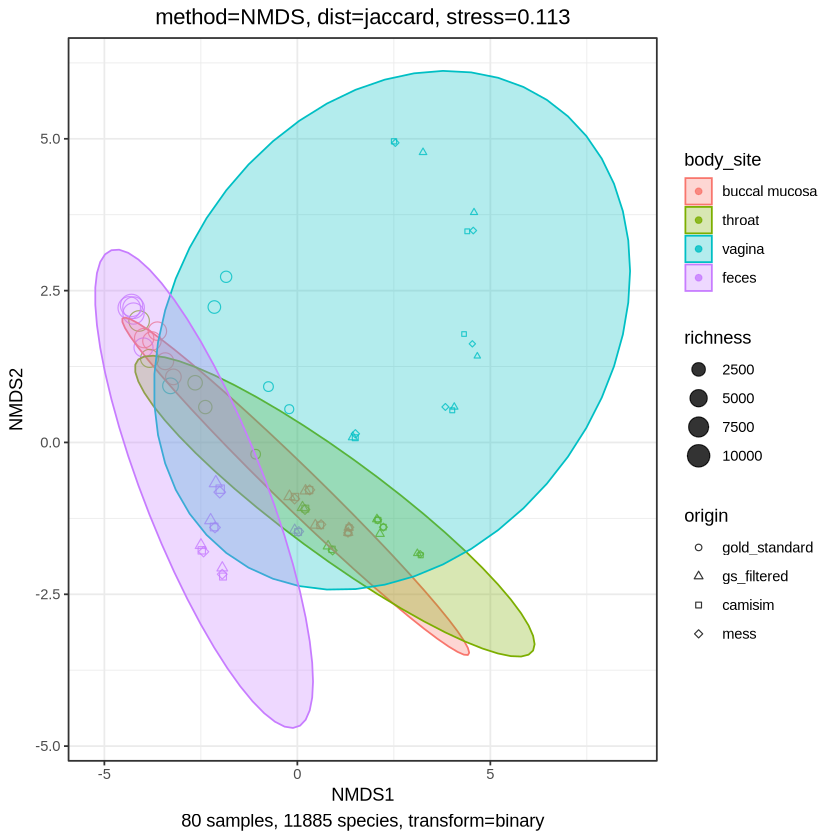

In [59]:
stress <-ord_get(ord)$stress
sample_count <- dim(samdat_tbl(ord))[1]
tax_count <- dim(tt_get(ord))[1]
p <- ord_plot(ord,
axes = c(1, 2),
auto_caption = NA,
colour = "body_site",
shape = "origin", alpha = 0.8,
size = "richness"
) + 
scale_shape_girafe_filled() +
stat_ellipse(geom = "polygon",aes(group = body_site, color = body_site, fill= body_site), alpha=0.3) +
theme_bw() +
ggtitle(sprintf("method=%s, dist=%s, stress=%s",method, dist,format(stress, digit=3))) +
labs(caption = sprintf("%s samples, %s %s, transform=%s",sample_count,tax_count,rank,trans)) +
theme(plot.caption = element_text(size = 11,hjust=0.5), plot.title = element_text(hjust=0.5))
p

In [60]:
ggsave(sprintf("figures/%s-%s-%s.png",rank,dist,method),p, dpi = 400, units = "in")

Saving 7 x 7 in image


## Bray

In [61]:
dist = "bray"
method = "NMDS"
trans = "identity"
rank <- "species"
mdist <- ps %>%
 tax_transform(rank = rank, trans = trans) %>%
 dist_calc(dist = dist)
ord <- 
 ord_calc(mdist,
  method = method
 )

Run 0 stress 0.1234994 
Run 1 stress 0.1234995 
... Procrustes: rmse 7.931263e-05  max resid 0.0001961988 
... Similar to previous best
Run 2 stress 0.1234995 
... Procrustes: rmse 4.879267e-05  max resid 0.0001172104 
... Similar to previous best
Run 3 stress 0.1359073 
Run 4 stress 0.1236369 
... Procrustes: rmse 0.003566404  max resid 0.01235771 
Run 5 stress 0.1236368 
... Procrustes: rmse 0.003560149  max resid 0.01233335 
Run 6 stress 0.1359073 
Run 7 stress 0.1359073 
Run 8 stress 0.1234995 
... Procrustes: rmse 6.995979e-05  max resid 0.0001719497 
... Similar to previous best
Run 9 stress 0.1234995 
... Procrustes: rmse 5.216842e-05  max resid 0.0001257338 
... Similar to previous best
Run 10 stress 0.135908 
Run 11 stress 0.1236371 
... Procrustes: rmse 0.003581985  max resid 0.01241711 
Run 12 stress 0.1234995 
... Procrustes: rmse 0.0001175894  max resid 0.0006793547 
... Similar to previous best
Run 13 stress 0.1413703 
Run 14 stress 0.1234994 
... Procrustes: rmse 1.98184

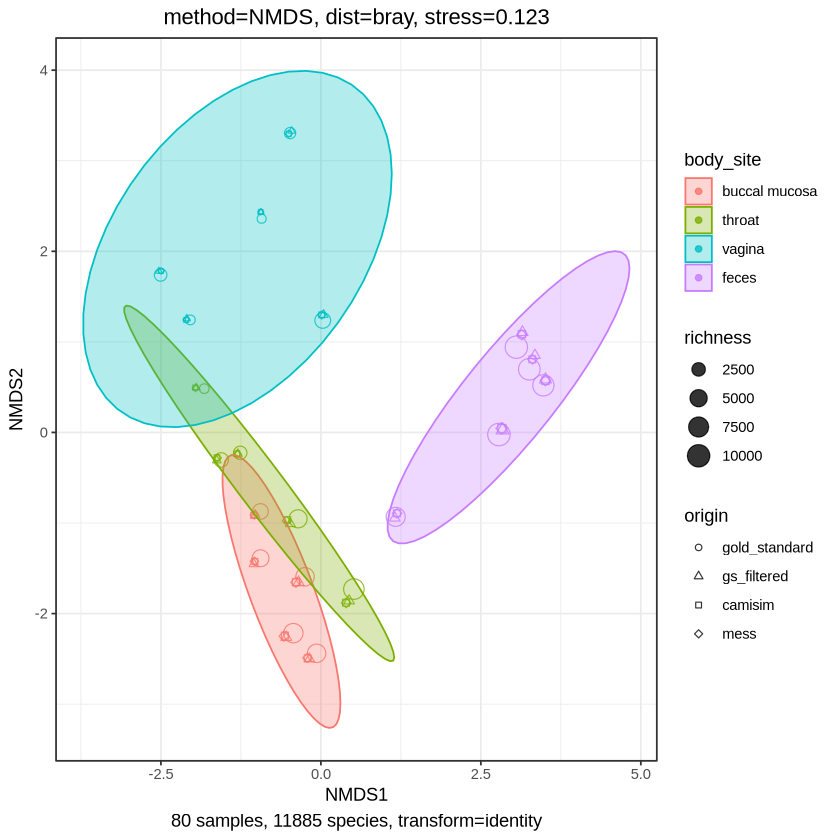

In [62]:
stress <-ord_get(ord)$stress
sample_count <- dim(samdat_tbl(ord))[1]
tax_count <- dim(tt_get(ord))[1]
p <- ord_plot(ord,
axes = c(1, 2),
auto_caption = NA,
colour = "body_site",
shape = "origin", alpha = 0.8,
size = "richness"
) + 
scale_shape_girafe_filled() +
stat_ellipse(geom = "polygon",aes(group = body_site, color = body_site, fill= body_site), alpha=0.3) +
theme_bw() +
ggtitle(sprintf("method=%s, dist=%s, stress=%s",method, dist,format(stress, digit=3))) +
labs(caption = sprintf("%s samples, %s %s, transform=%s",sample_count,tax_count,rank,trans)) +
theme(plot.caption = element_text(size = 11,hjust=0.5), plot.title = element_text(hjust=0.5))
p

In [63]:
ggsave(sprintf("figures/%s-%s-%s.png",rank,dist,method),p, dpi = 400, units = "in")

Saving 7 x 7 in image


## PERMANOVA

In [64]:
perm <- dist_permanova(mdist,
    variables = "origin:simulated+body_site",
    n_perms = 999, 
    n_processes = 3
)
perm

2024-10-22 09:20:33.553781 - Starting PERMANOVA with 999 perms with 3 processes

2024-10-22 09:20:33.687164 - Finished PERMANOVA



psExtra object - a phyloseq object with extra slots:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11885 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 11885 taxa by 7 taxonomic ranks ]

psExtra info:
tax_agg = "species" tax_trans = "identity" 

bray distance matrix of size 80 
0.01086067 0.8933017 0.8976926 0.8829079 0.8906677 ...

permanova:
Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 999

vegan::adonis2(formula = formula, data = metadata, permutations = n_perms, by = by, parallel = parall)
                 Df SumOfSqs      R2       F Pr(>F)    
body_site         3   12.762 0.39659 16.0461  0.001 ***
origin:simulated  3    0.064 0.00198  0.0803  1.000    
Residual         73   19.353 0.60142                   
Total            79   32.179 1.00000                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.

## Beta dispersion

In [65]:
bd <- dist_bdisp(mdist, variables = c("origin","simulated","body_site")) %>%  bdisp_get()
bd

$origin
$origin$model

	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = distMat, group = meta[[V]], type = method)

No. of Positive Eigenvalues: 42
No. of Negative Eigenvalues: 37

Average distance to centroid:
gold_standard   gs_filtered       camisim          mess 
       0.6315        0.6340        0.6328        0.6327 

Eigenvalues for PCoA axes:
(Showing 8 of 79 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
6.031 5.106 3.800 3.236 2.709 1.966 1.384 1.291 

$origin$anova
Analysis of Variance Table

Response: Distances
          Df   Sum Sq    Mean Sq F value Pr(>F)
Groups     3 0.000061 0.00002036  0.0176 0.9968
Residuals 76 0.087837 0.00115575               

$origin$tukeyHSD
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                   diff         lwr        upr     p adj
gs_filtered-gold_standard  2.469899e-03 -0.02576974 0.03070954 0.99

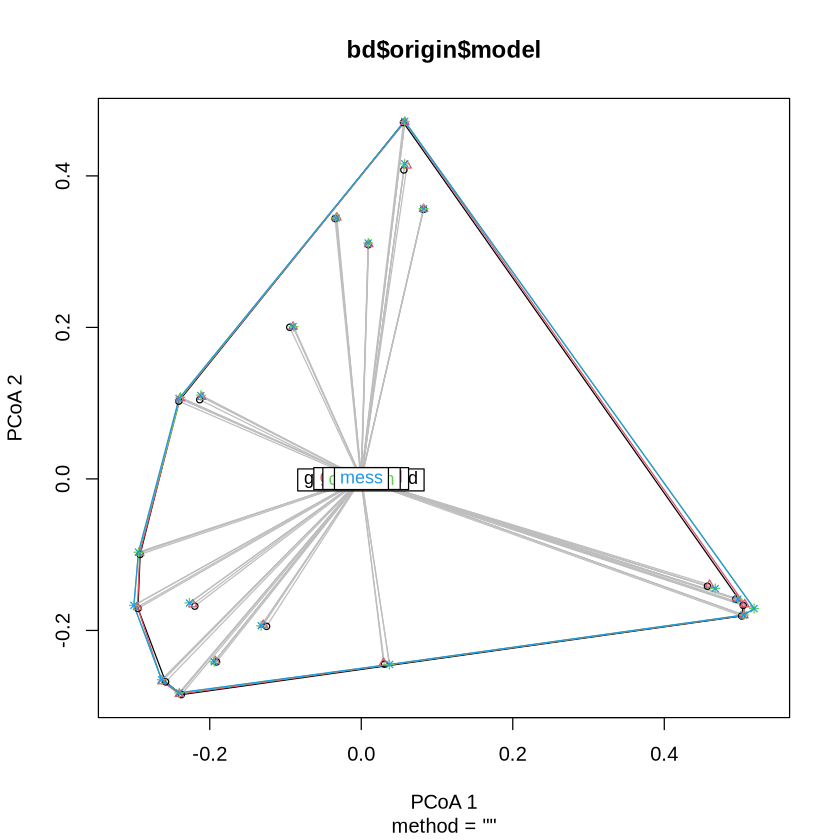

In [66]:
plot(bd$origin$model, label.cex = 0.9)

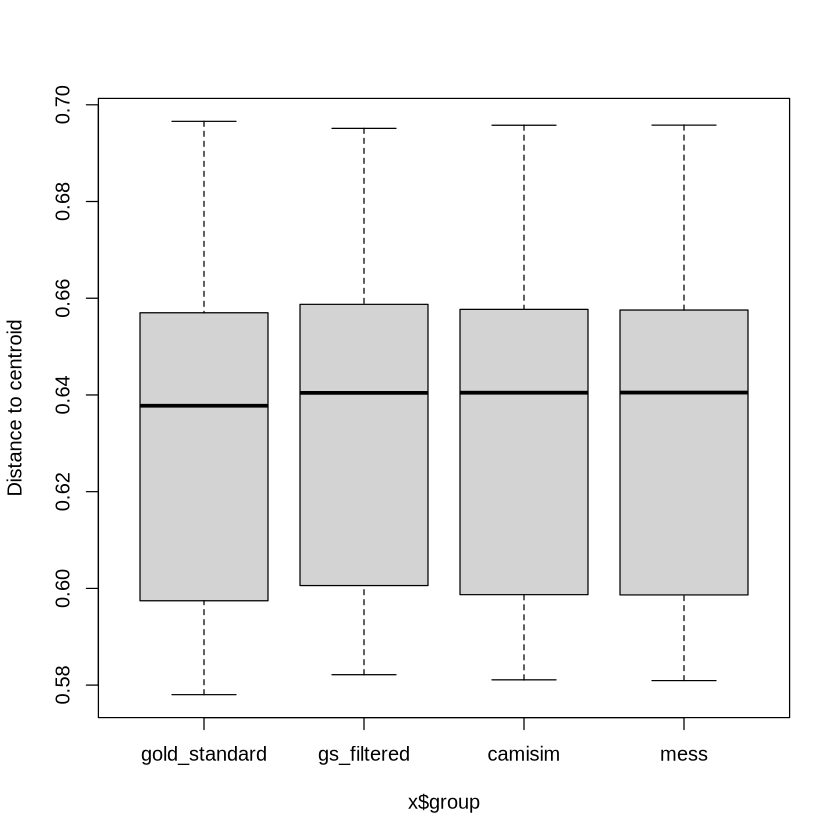

In [67]:
boxplot(bd$origin$model)

## Alpha diversities

In [68]:
alphadiv <- estimate_richness(ps, measures = c("Observed","Chao1","Shannon","Simpson",'InvSimpson'))
alphadiv$file <- rownames(alphadiv)
alphadiv <- inner_join(alphadiv, SAM, by="file") # add sample metadata
alphadiv <- subset(alphadiv, select = -c(richness,se.chao1,file))
alphadiv <- melt(alphadiv)
names(alphadiv) <- c("sample","origin","bodysite", "simulated","alpha","value")

Using sample, origin, body_site, simulated as id variables



In [69]:
head(alphadiv)

,sample,origin,bodysite,simulated,alpha,value
,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,SRS013506,gold_standard,buccal mucosa,False,Observed,6033
2,SRS013506,gs_filtered,buccal mucosa,False,Observed,429
3,SRS014475,gold_standard,throat,False,Observed,3030
4,SRS014475,gs_filtered,throat,False,Observed,112
5,SRS014689,gold_standard,throat,False,Observed,8005
6,SRS014689,gs_filtered,throat,False,Observed,333


In [70]:
sim_alpha <- subset(alphadiv,origin=='mess')
names(sim_alpha)[names((sim_alpha))=='value']='sim_alpha'
real_alpha <- subset(alphadiv,origin=='gold_standard')
names(real_alpha)[names((real_alpha))=='value']='real_alpha'
df=cbind(real_alpha,sim_alpha)
df=subset(df, select=which(!duplicated(names(df)))) 
r <- 'spearman'
cor=round(cor(df$sim_alpha, df$real_alpha, method = r), 3)
cors <- ddply(df, c("alpha"), summarise, cor=round(cor(real_alpha, sim_alpha,method=r), 5))
cors$x=c(200,200,1.25,0.29,6.5)
cors$y=c(11000,11000,3,0.6,20)
cors$r2=round(cors$cor^2,2)
c <- ggplot(df,aes(x=sim_alpha,y=real_alpha))+geom_point()
c <- c+facet_wrap(~alpha,scales='free',ncol = 2)+geom_smooth(method = "lm", se = TRUE)
c <- c + geom_text(data=cors, aes(x=x,y=y,label=paste(r,"'s ","r2=", r2, sep="")))

`geom_smooth()` using formula = 'y ~ x'


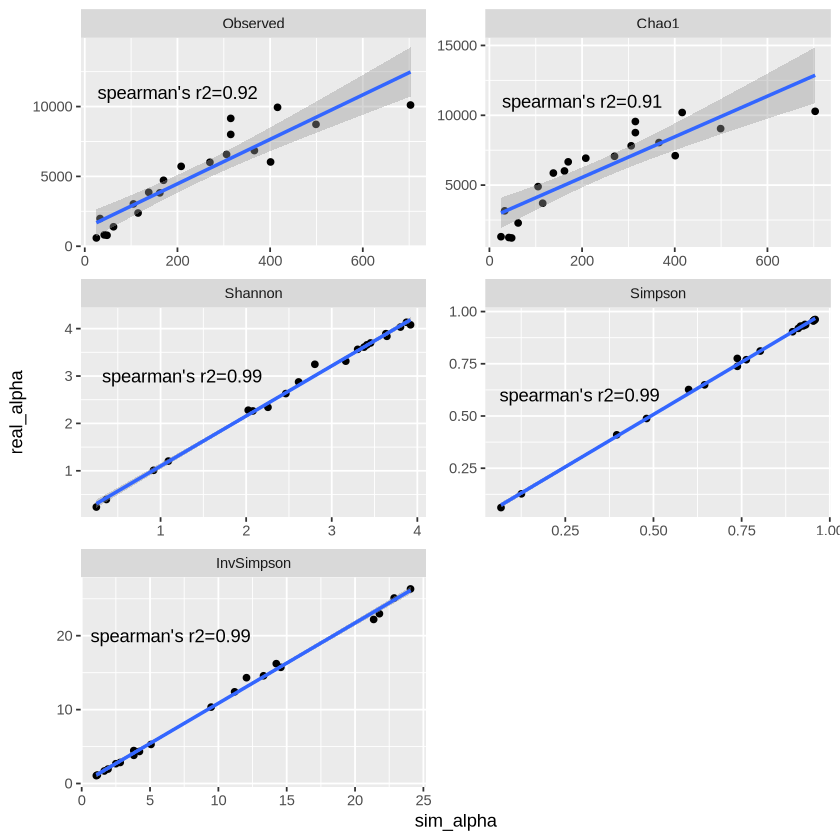

In [71]:
c

In [72]:
ggsave("figures/alpha-divs.png",c, dpi = 400, units = "in")

Saving 7 x 7 in image
`geom_smooth()` using formula = 'y ~ x'
